# Survival Analysis - Brand A's campaign effectiveness
    [X] Data taken from a database with brand A
    [X] Data from the last 12 months was taken to see whether the campaign was effective in increasing customer retention
    [X] Effectiveness can be seen from the campaign provided and comparing the control and treatment segments
        [X] treatment and control campaign 1
        [X] treatment and control campaign 2
        [X] treatment and control campaign 3
        [X] treatment and control campaign 4
    [X] Analysis is carried out by looking at how long it takes the customer to make the first transaction after the campaign

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import pyodbc #untuk connect sql 
import datetime
import warnings
from lifelines import KaplanMeierFitter

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)


In [2]:
# Konfigurasi koneksi ke SQL Server
server = 'server'
database = 'database'
username = 'username'
password = 'password'
# Buat koneksi
connection = pyodbc.connect('DRIVER={SQL Server};SERVER='+server+';DATABASE='+database+';UID='+username+';PWD='+ password)

In [3]:
# Query menarik data dari SQL Server
query = """
WITH Tabel1 AS
	(
	SELECT KontakId, 
		LEFT(NomorHandphone,4) + REPLICATE('X',LEN(NomorHandphone)-6) + RIGHT(NomorHandphone,2) NomorHandphone,
		LEFT(NamaCampaign,2) + REPLICATE('X',LEN(NamaCampaign)-3) + RIGHT(NamaCampaign,1) NamaCampaign,  
		GroupSegmen, Created_Date
	FROM Tabel1 WITH(NOLOCK)
	WHERE Created_Date >= DATEADD(MONTH, -6, GETDATE())
		AND ProductCategory = 'Brand A'
	),
Tabel2 AS
	(
	SELECT KontakId, PurchasedDate
	FROM Tabel2 WITH(NOLOCK)
	WHERE PurchasedDate >= DATEADD(MONTH, -6, GETDATE())
		AND ProductCategory = 'Brand A'
	)

SELECT *
FROM
	(
	SELECT Tabel1.KontakId, Tabel1.NomorHandphone, Tabel1.NamaCampaign, 
		LOWER(Tabel1.GroupSegmen) GroupSegmen, Tabel1.Created_Date, Tabel2.PurchasedDate,
		CASE WHEN Tabel2.PurchasedDate IS NULL THEN 1
			ELSE ROW_NUMBER() OVER(PARTITION BY Tabel2.KontakID, Tabel1.Created_Date ORDER BY Tabel2.PurchasedDate ASC)
			END Ranking, ---mengambil transaksi pertama setelah mendapat blast wa
		CASE WHEN Tabel2.PurchasedDate IS NOT NULL THEN DATEDIFF(DAY, Tabel1.Created_date, Tabel2.PurchasedDate) 
			ELSE DATEDIFF(DAY, Created_date, GETDATE()) 
			END Survival_Time, ---mengambil lamanya hari setelah blast wa ke trx pertama
		CASE WHEN Tabel2.PurchasedDate IS NULL THEN 0 ELSE 1 END Event_Occurred
	FROM Tabel1
	LEFT JOIN Tabel2
	ON Tabel1.KontakId = Tabel2.KontakID
		AND Tabel1.Created_Date < Tabel2.PurchasedDate
	)Data
WHERE Ranking = 1
"""

data_raw= pd.read_sql(query, connection)

In [4]:
data_raw.shape

(378960, 9)

In [27]:
data_raw.to_excel(r'20240224_campaign_segmen.xlsx')
#data_raw = pd.read_excel(r'20240224_campaign_segmen.xlsx')
#data_raw = data_raw.drop(['Unnamed: 0'], axis=1)
df = data_raw.copy()
df.head()

KontakId NomorHandphone NamaCampaign GroupSegmen Created_Date  \
0  2301-SPG463D   0821XXXXXX78   SuXXXXXXXs   treatment   2023-09-04   
1  2307-YX04700  0895XXXXXXX27   SuXXXXXXXs   treatment   2023-09-04   
2  2308-SPGAF9E   0821XXXXXX73   SuXXXXXXXs   treatment   2023-09-04   
3  082233972005   0822XXXXXX05   SuXXXXXXXs   treatment   2023-09-04   
4  2106-PW40601   0812XXXXXX64   SuXXXXXXXs   treatment   2023-09-04   

  PurchasedDate  Ranking  Survival_Time  Event_Occurred  
0           NaN        1            177               0  
1           NaN        1            177               0  
2           NaN        1            177               0  
3           NaN        1            177               0  
4           NaN        1            177               0

In [28]:
df['GroupSegmen'].value_counts()

GroupSegmen
treatment    336242
control       42718
Name: count, dtype: int64

In [29]:
# Create the pivot table
pivot_table = df.pivot_table(values='KontakId', index='NamaCampaign', columns='Event_Occurred', aggfunc='count', fill_value=0)

# Display the pivot table
print(pivot_table)

Event_Occurred            0      1
NamaCampaign                      
AcXXXXXXXXXXXXXXXXXe  94384   3997
AcXXXXXXXXXXXXXXt      5569   7895
ChXXn                 69204  29047
SuXXXXXXXs            99413  69451


In [30]:
df_control = df[(df['GroupSegmen'] == 'control')]
df_treatment = df[(df['GroupSegmen'] == 'treatment')]

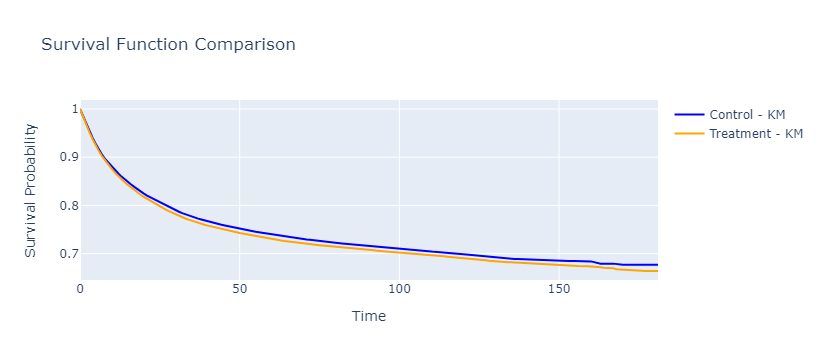

In [31]:
# Install required libraries if not already installed
# pip install plotly lifelines

import pandas as pd
from lifelines import KaplanMeierFitter
import plotly.graph_objects as go

# List of dataframes and their respective colors
datasets = [
    (df_control, df_treatment, 'KM', 'blue', 'orange')
]

# Create a plotly figure
fig = go.Figure()

# Loop through each dataset and add survival functions to the plot
for df_control, df_treatment, campaign_name, control_color, treatment_color in datasets:
    kmf_control = KaplanMeierFitter()
    kmf_control.fit(durations=df_control['Survival_Time'], event_observed=df_control['Event_Occurred'])

    kmf_treatment = KaplanMeierFitter()
    kmf_treatment.fit(durations=df_treatment['Survival_Time'], event_observed=df_treatment['Event_Occurred'])

    # Add survival function for control group
    fig.add_trace(go.Scatter(x=kmf_control.timeline, y=kmf_control.survival_function_.values.flatten(),
                             mode='lines', name=f'Control - {campaign_name}', line=dict(color=control_color)))

    # Add survival function for treatment group
    fig.add_trace(go.Scatter(x=kmf_treatment.timeline, y=kmf_treatment.survival_function_.values.flatten(),
                             mode='lines', name=f'Treatment - {campaign_name}', line=dict(color=treatment_color)))

# Customize the layout
fig.update_layout(
    title='Survival Function Comparison',
    xaxis_title='Time',
    yaxis_title='Survival Probability',
)

# Show the combined plot
fig.show()


The control segment tends to buy more quickly than customers who receive blast wa treatment. Next, we will see which campaign has a faster influence in influencing customers to make transactions.

In [32]:
df_control_campaign1 = df[(df['GroupSegmen'] == 'control') & (df['NamaCampaign'] == 'AcXXXXXXXXXXXXXXXXXe')]
df_treatment_campaign1 = df[(df['GroupSegmen'] == 'treatment') & (df['NamaCampaign'] == 'AcXXXXXXXXXXXXXXXXXe')]
df_control_campaign2 = df[(df['GroupSegmen'] == 'control') & (df['NamaCampaign'] == 'AcXXXXXXXXXXXXXXt')]
df_treatment_campaign2 = df[(df['GroupSegmen'] == 'treatment') & (df['NamaCampaign'] == 'AcXXXXXXXXXXXXXXt')]
df_control_campaign3 = df[(df['GroupSegmen'] == 'control') & (df['NamaCampaign'] == 'ChXXn')]
df_treatment_campaign3 = df[(df['GroupSegmen'] == 'treatment') & (df['NamaCampaign'] == 'ChXXn')]
df_control_campaign4 = df[(df['GroupSegmen'] == 'control') & (df['NamaCampaign'] == 'SuXXXXXXXs')]
df_treatment_campaign4 = df[(df['GroupSegmen'] == 'treatment') & (df['NamaCampaign'] == 'SuXXXXXXXs')]

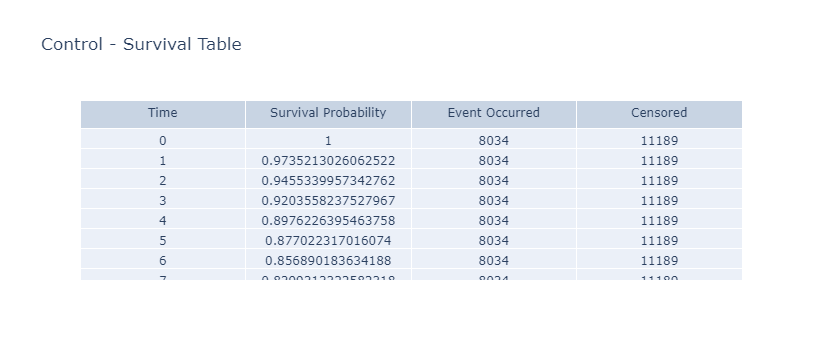

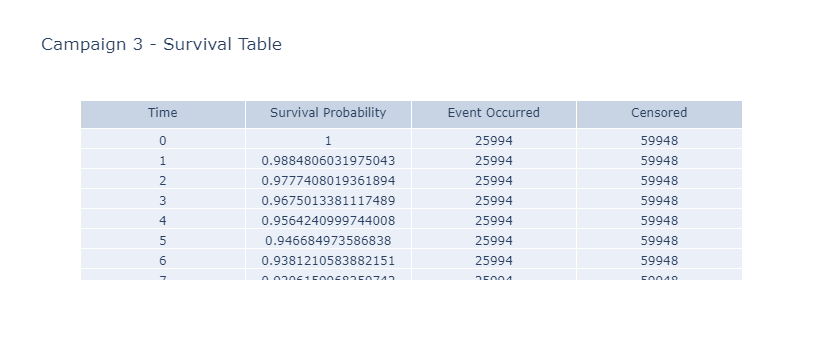

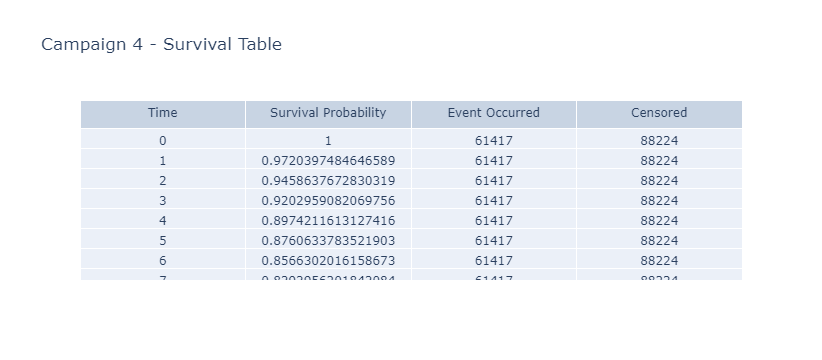

In [47]:
import pandas as pd
from lifelines import KaplanMeierFitter
import plotly.graph_objects as go

# Assuming df_delivered, df_failed, df_read, df_sent are the DataFrames

def create_survival_table(df, title):
    kmf = KaplanMeierFitter()
    kmf.fit(durations=df['Survival_Time'], event_observed=df['Event_Occurred'])

    # Create a plotly figure for the group
    fig = go.Figure(data=[go.Table(
        header=dict(values=['Time', 'Survival Probability', 'Event Occurred', 'Censored']),
        cells=dict(values=[kmf.timeline,
                           kmf.survival_function_.values.flatten(),
                           [kmf.event_observed.sum()] * len(kmf.timeline),
                           [len(df) - kmf.event_observed.sum()] * len(kmf.timeline)])
    )])

    # Update layout for the table
    fig.update_layout(title=f'{title} - Survival Table')

    # Show the interactive table
    fig.show()

# List of datasets and their titles
datasets = [
    (df_control, 'Control'),
    (df_treatment_campaign1, 'Campaign 1'),
    (df_treatment_campaign2, 'Campaign 2'),
    (df_treatment_campaign3, 'Campaign 3'),
    (df_treatment_campaign4, 'Campaign 4')
]

# Loop through each dataset and create survival tables
for df, title in datasets:
    create_survival_table(df, title)

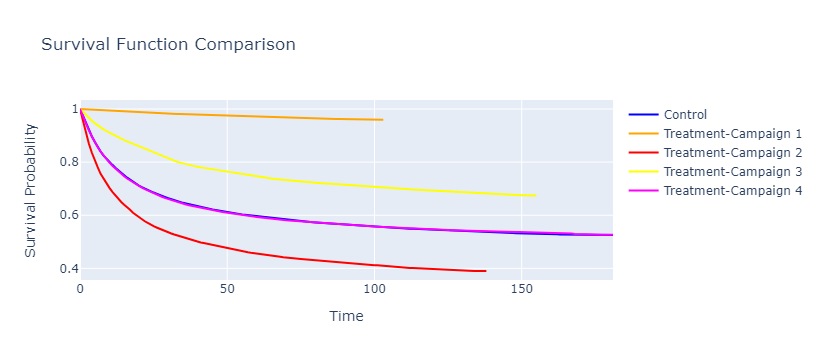

In [36]:
# Install required libraries if not already installed
# pip install plotly lifelines

import pandas as pd
from lifelines import KaplanMeierFitter
import plotly.graph_objects as go

# List of dataframes and their respective colors
datasets = [
    (df_control, 'Control', 'blue'),
    (df_treatment_campaign1, 'Treatment-Campaign 1', 'orange'),
    (df_treatment_campaign2, 'Treatment-Campaign 2', 'red'),
    (df_treatment_campaign3, 'Treatment-Campaign 3', 'yellow'),
    (df_treatment_campaign4, 'Treatment-Campaign 4', 'magenta')
]

# Create a plotly figure
fig = go.Figure()

# Loop through each dataset and add survival functions to the plot
for df, campaign_name, line_color in datasets:
    kmf = KaplanMeierFitter()
    kmf.fit(durations=df['Survival_Time'], event_observed=df['Event_Occurred'])

    # Add survival function for the group
    fig.add_trace(go.Scatter(x=kmf.timeline, y=kmf.survival_function_.values.flatten(),
                             mode='lines', name=campaign_name, line=dict(color=line_color)))

# Customize the layout
fig.update_layout(
    title='Survival Function Comparison',
    xaxis_title='Time',
    yaxis_title='Survival Probability',
    showlegend=True,  # Set to True to display the legend
)

# Show the combined plot
fig.show()


The graph above shows that treatment campaign 1 and campaign 3 have a higher effectiveness value than control in increasing customer retain value. Meanwhile, campaign 4 has the same effectiveness value as control and campaign 2 has lower effectiveness compared to control.